# UNEVENLY DISTRIBUTED CASE

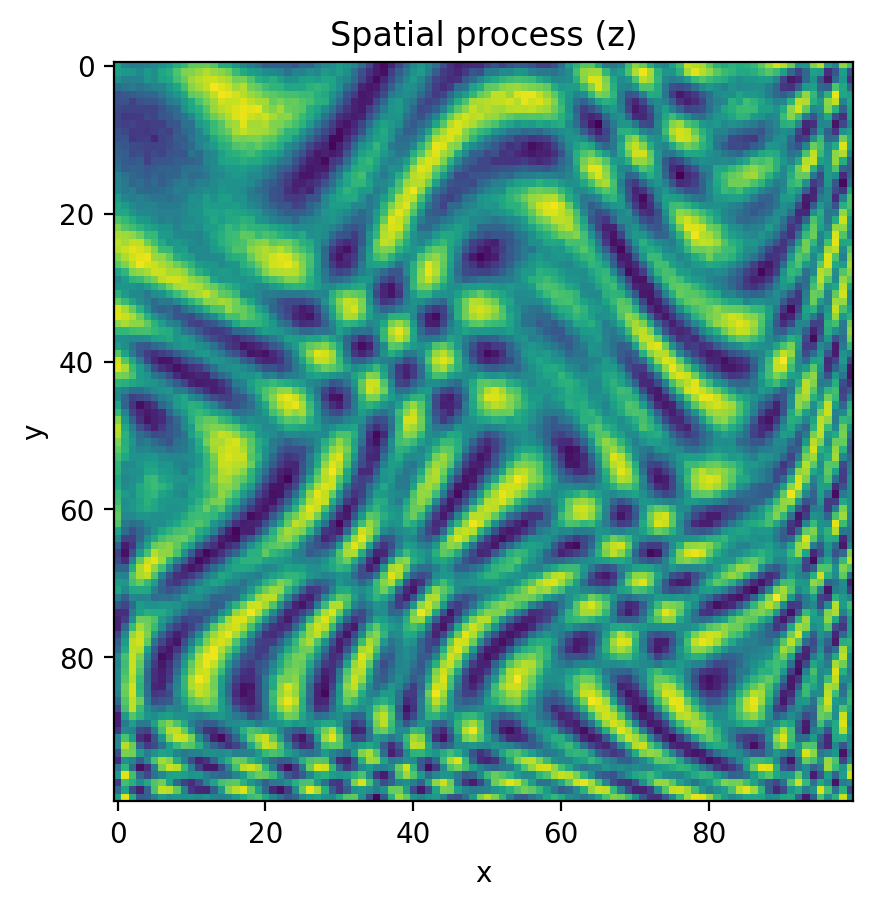

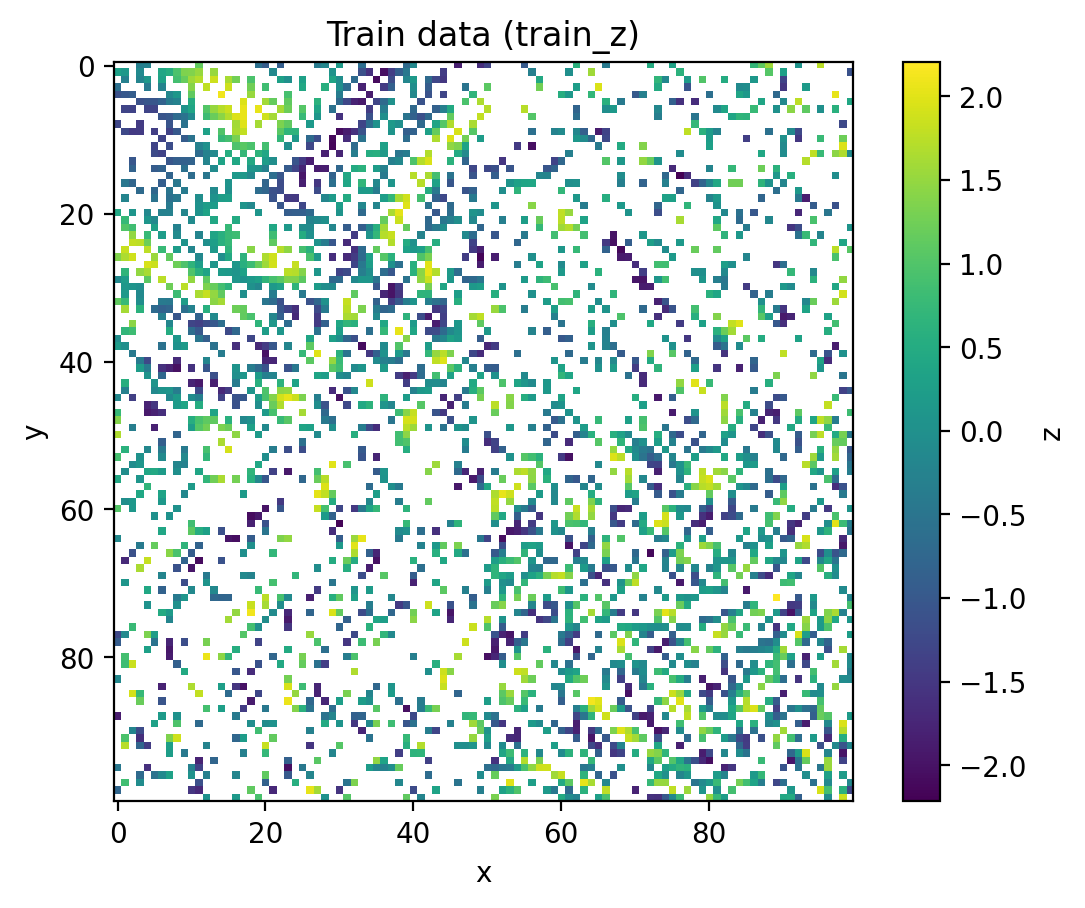

In [82]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import numpy as np
from numpy.linalg import cholesky, solve
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

import scipy.io

# load the data from the mat file
data = scipy.io.loadmat('spatial_data.mat')
z = data['z'] # the ground truth data
train_z = data['train_z'] # the training data

# Visualize the spatial process in 2D heatmap format
x, y = np.meshgrid(np.linspace(0, 100, 100), np.linspace(0, 100, 100))
fig = plt.figure()
ax = plt.axes()
ax.imshow(z, cmap='viridis')
ax.set_title('Spatial process (z)')
ax.set_xlabel('x')
ax.set_ylabel('y')

# train data in 2D heatmap format
fig2 = plt.figure()
ax2 = plt.axes()
im2 = ax2.imshow(train_z, cmap='viridis')
ax2.set_title('Train data (train_z)')
ax2.set_xlabel('x')
ax2.set_ylabel('y')

# add a color bar to the plot to show the value of z
cbar = plt.colorbar(im2, ax=ax2)
cbar.set_label('z')
plt.show()


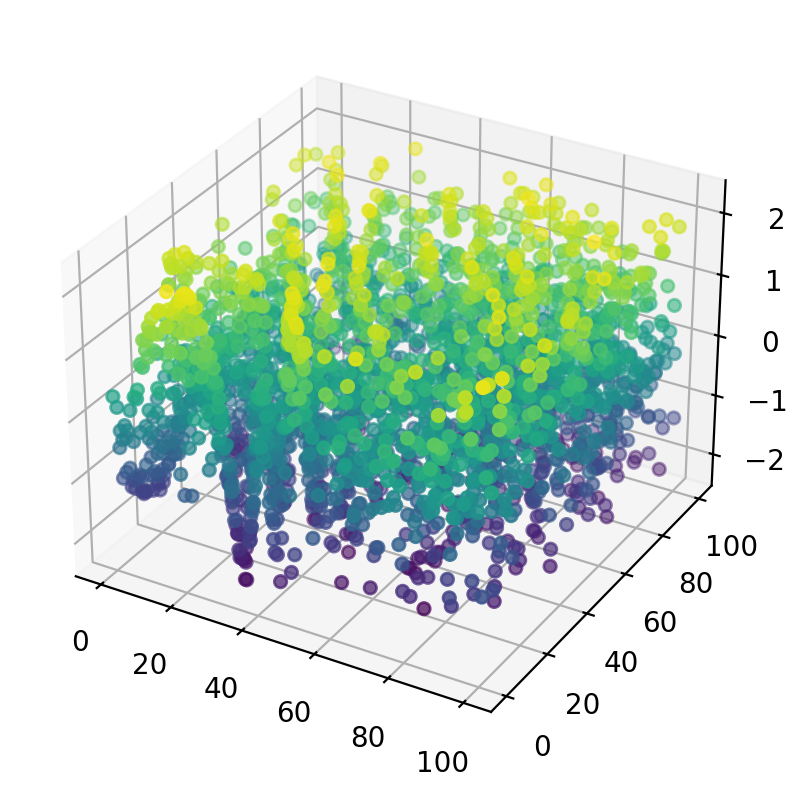

In [83]:
%matplotlib inline
rows, cols = np.where(~np.isnan(train_z))
xg, yg = np.meshgrid(np.linspace(0, 100, train_z.shape[1]),
                     np.linspace(0, 100, train_z.shape[0]))
train_x = xg[rows, cols]
train_y = yg[rows, cols]
train_z = train_z[rows, cols]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(train_x, train_y, train_z, c=train_z, cmap='viridis')
plt.show()


In [84]:
# Define the kernels and likelihood
def SE_kernel(x1, x2,  l2, s2=1):
    """Squared Exponential kernel
    ----------
    x1,x2: np.array, n by 1 input array
    l2: positive float, (length scale)^2
    s2: float, sigma^2
    """
    return s2*np.exp(-(x1.reshape([-1,1]) - x2.reshape([1,-1]))**2/l2)


def SE_kernel_2d(x1, x2, kernel_params):
    """Wrap a 2D SE kernel function for optimization
    ----------
    x1,x2: np.array, n by 2 input array
    kernel_params: np.array, kernel parameters
    """
    SE_l2 = kernel_params[0]
    SE_s2 = kernel_params[1]
    return SE_kernel(x1[:,0], x2[:,0], l2=SE_l2, s2=SE_s2) * SE_kernel(x1[:,1], x2[:,1], l2=SE_l2, s2=1)


def white_noise_kernel(x1, x2, e2=1):
    """White noise kernel
    ----------
    x1,x2: np.array, n by 1 input array
    e2: positive float, variance
    """
    if x1.shape == x2.shape:
        return e2*np.eye(x1.shape[0])
    else:
        raise ValueError("x1 and x2 should have the same shape")


In [85]:
# Maximum Likelihood Estimation for Gaussian Process to find the best kernel parameters and noise variance
def log_marginal_likelihood(x, y, kernel, kernel_params, e2):
    """Log marginal likelihood
    ----------
    x: np.array, n by d input array
    y: np.array, n by d output array
    kernel: function, kernel function
    kernel_params: np.array, kernel parameters
    e2: float, noise variance
    """
    K = kernel(x, x, kernel_params) + white_noise_kernel(x, x, e2)
    L = cholesky(K)
    alpha = solve(L.T, solve(L, y))
    lml = -0.5 * y.T.dot(alpha) - np.sum(np.log(np.diag(L))) - x.shape[0] / 2 * np.log(2 * np.pi)
    return lml

In [86]:
# prepare the training data 
train_X = np.concatenate([train_x.reshape([-1,1]), train_y.reshape([-1,1])], axis=1) 

# define the negative log likelihood function
def NLL(params):
    """Negative log likelihood
    ----------
    params: np.array, kernel parameters and noise variance
    """
    kernel_params = params[:-1] # kernel parameters
    e2 = params[-1] # noise variance
    return -log_marginal_likelihood(train_X, train_z, SE_kernel_2d, kernel_params, e2) 

# # We use scipy minimize to optimize the negative log likelihood.
# # Note that we did not give the gradient information. So the optimization will be slow.
# from scipy.optimize import minimize
# res = minimize(NLL,
#                x0=np.array([1, 1, 0.05]),  # initial values
#                method='L-BFGS-B', # limited-memory BFGS Bounded algorithm
#                bounds=((1e-5, None), (1e-5, None), (1e-5, None)))  # bounds for the parameters

In [87]:
# grid search
from scipy.optimize import minimize

# Define minimal grid search ranges
l2_init = [0.5, 1, 2]      # length scale squared  
s2_init = [0.5, 1, 2]      # signal variance
e2_init = [0.01, 0.1]      # noise variance

# Store results
results = []
best_nll = float('inf')
best_result = None
best_init = None

total_combinations = len(l2_init) * len(s2_init) * len(e2_init)
print(f"Starting grid search with {total_combinations} combinations...")

combination_count = 0
for _l2 in l2_init:
    for _s2 in s2_init:
        for _e2 in e2_init:
            combination_count += 1
            print(f"Combination {combination_count}/{total_combinations}: l2={_l2}, s2={_s2}, e2={_e2}")
            
            try:
                temp = minimize(NLL, 
                              x0=np.array([_l2, _s2, _e2]), 
                              method='L-BFGS-B', 
                              bounds=((1e-5, None), (1e-5, None), (1e-5, None)),
                              options={'maxiter': 20})
                
                results.append({
                    'init': [_l2, _s2, _e2],
                    'optimized': temp.x,
                    'nll': temp.fun,
                    'success': temp.success
                })
                
                if temp.fun < best_nll and temp.success:
                    best_nll = temp.fun
                    best_result = temp
                    best_init = [_l2, _s2, _e2]
                    
                print(f"  NLL: {temp.fun:.4f}, Success: {temp.success}")
                
            except Exception as e:
                print(f"  Error: {e}")
                continue

print(f"\n{'='*60}")
print(f"Grid search completed!")
print(f"{'='*60}")
if best_result is not None:
    print(f"Best initial values: {best_init}")
    print(f"Best optimized parameters: {best_result.x}")
    print(f"Best NLL: {best_nll:.4f}")
    res = best_result
else:
    print("No successful optimization found!")

Starting grid search with 18 combinations...
Combination 1/18: l2=0.5, s2=0.5, e2=0.01
  NLL: 2225.9587, Success: True
Combination 2/18: l2=0.5, s2=0.5, e2=0.1
  NLL: 2225.9587, Success: True
Combination 3/18: l2=0.5, s2=1, e2=0.01
  NLL: 2225.9587, Success: True
Combination 4/18: l2=0.5, s2=1, e2=0.1
  NLL: 2225.9587, Success: True
Combination 5/18: l2=0.5, s2=2, e2=0.01
  NLL: 2225.9587, Success: True
Combination 6/18: l2=0.5, s2=2, e2=0.1
  NLL: 2225.9587, Success: False
Combination 7/18: l2=1, s2=0.5, e2=0.01
  NLL: 2225.9587, Success: True
Combination 8/18: l2=1, s2=0.5, e2=0.1
  NLL: 2225.9587, Success: True
Combination 9/18: l2=1, s2=1, e2=0.01
  NLL: 2225.9587, Success: True
Combination 10/18: l2=1, s2=1, e2=0.1
  NLL: 2225.9587, Success: True
Combination 11/18: l2=1, s2=2, e2=0.01
  NLL: 2225.9733, Success: False
Combination 12/18: l2=1, s2=2, e2=0.1
  NLL: 2225.9587, Success: False
Combination 13/18: l2=2, s2=0.5, e2=0.01
  NLL: 2225.9587, Success: True
Combination 14/18: l2=

In [88]:
print(best_result)

print(results)

  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 2225.9586964998252
        x: [ 5.556e+00  9.837e-01  1.538e-02]
      nit: 14
      jac: [ 1.819e-04 -9.095e-05 -4.093e-03]
     nfev: 80
     njev: 20
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
[{'init': [0.5, 0.5, 0.01], 'optimized': array([5.55571101, 0.98374764, 0.01538263]), 'nll': np.float64(2225.958696508542), 'success': True}, {'init': [0.5, 0.5, 0.1], 'optimized': array([5.55569973, 0.98374732, 0.01538259]), 'nll': np.float64(2225.958696500439), 'success': True}, {'init': [0.5, 1, 0.01], 'optimized': array([5.55569603, 0.98374556, 0.01538251]), 'nll': np.float64(2225.958696503086), 'success': True}, {'init': [0.5, 1, 0.1], 'optimized': array([5.55574233, 0.98374654, 0.01538281]), 'nll': np.float64(2225.9586965877434), 'success': True}, {'init': [0.5, 2, 0.01], 'optimized': array([5.55569658, 0.98374679, 0.01538258]), 'nll': np.float64(2225.9586964998252), 'succ

In [89]:
# We use scipy minimize to optimize the negative log likelihood.
# Note that we did not give the gradient information. So the optimization will be slow.
from scipy.optimize import minimize
res = minimize(NLL,
               x0=np.array([0.5, 2, 0.01]),  # initial values - best from grid search
               method='L-BFGS-B', # limited-memory BFGS Bounded algorithm
               bounds=((1e-5, None), (1e-5, None), (1e-5, None)))  # bounds for the parameters

In [90]:
# Define the prediction function
def prediction(X, y, X_star, kernel, kernel_params, e2, return_std=False):
    """Prediction
    ----------
    X: np.array, n by d input array at observed points
    y: np.array, n by d output array at observed points
    X_star: np.array, m by d input array at unknown points
    kernel: function, kernel function
    kernel_params: np.array, kernel parameters
    e2: float, noise variance

    return:
    -------
    mean: np.array, m by 1 mean of the predictive distribution
    covariances: np.array, m by m covariance matrix of the predictive distribution
    """
    # calculate the kernel matrix   
    K = kernel(X, X, kernel_params) + white_noise_kernel(X, X, e2)
    K_star = kernel(X_star, X, kernel_params)
    K_star_star = kernel(X_star, X_star, kernel_params)

    # predict the mean and covariance
    L = cholesky(K)
    alpha = solve(L.T, solve(L, y))
    v = solve(L, K_star.T)
    mean = K_star.dot(alpha)

    # return the mean and covariance if return_std is True
    if return_std:
        covariances = K_star_star - v.T.dot(v)
        return mean, covariances
    else:
        return mean

# test the prediction function
test_X = np.concatenate([x.reshape([-1,1]), y.reshape([-1,1])], axis=1) # test data
# predict the mean and covariance
z_gp, cov_gp = prediction(train_X, train_z, test_X, SE_kernel_2d, res.x[:-1], res.x[-1], return_std=True)
# reshape the mean and covariance to the shape of the meshgrid
z_gp = z_gp.reshape(x.shape)
std_gp = np.sqrt(np.diag(cov_gp)).reshape(x.shape)

In [91]:
res.x   # optimized parameters [optimal length scale, optimal signal variance, optimal noise variance]

array([5.55569658, 0.98374679, 0.01538258])

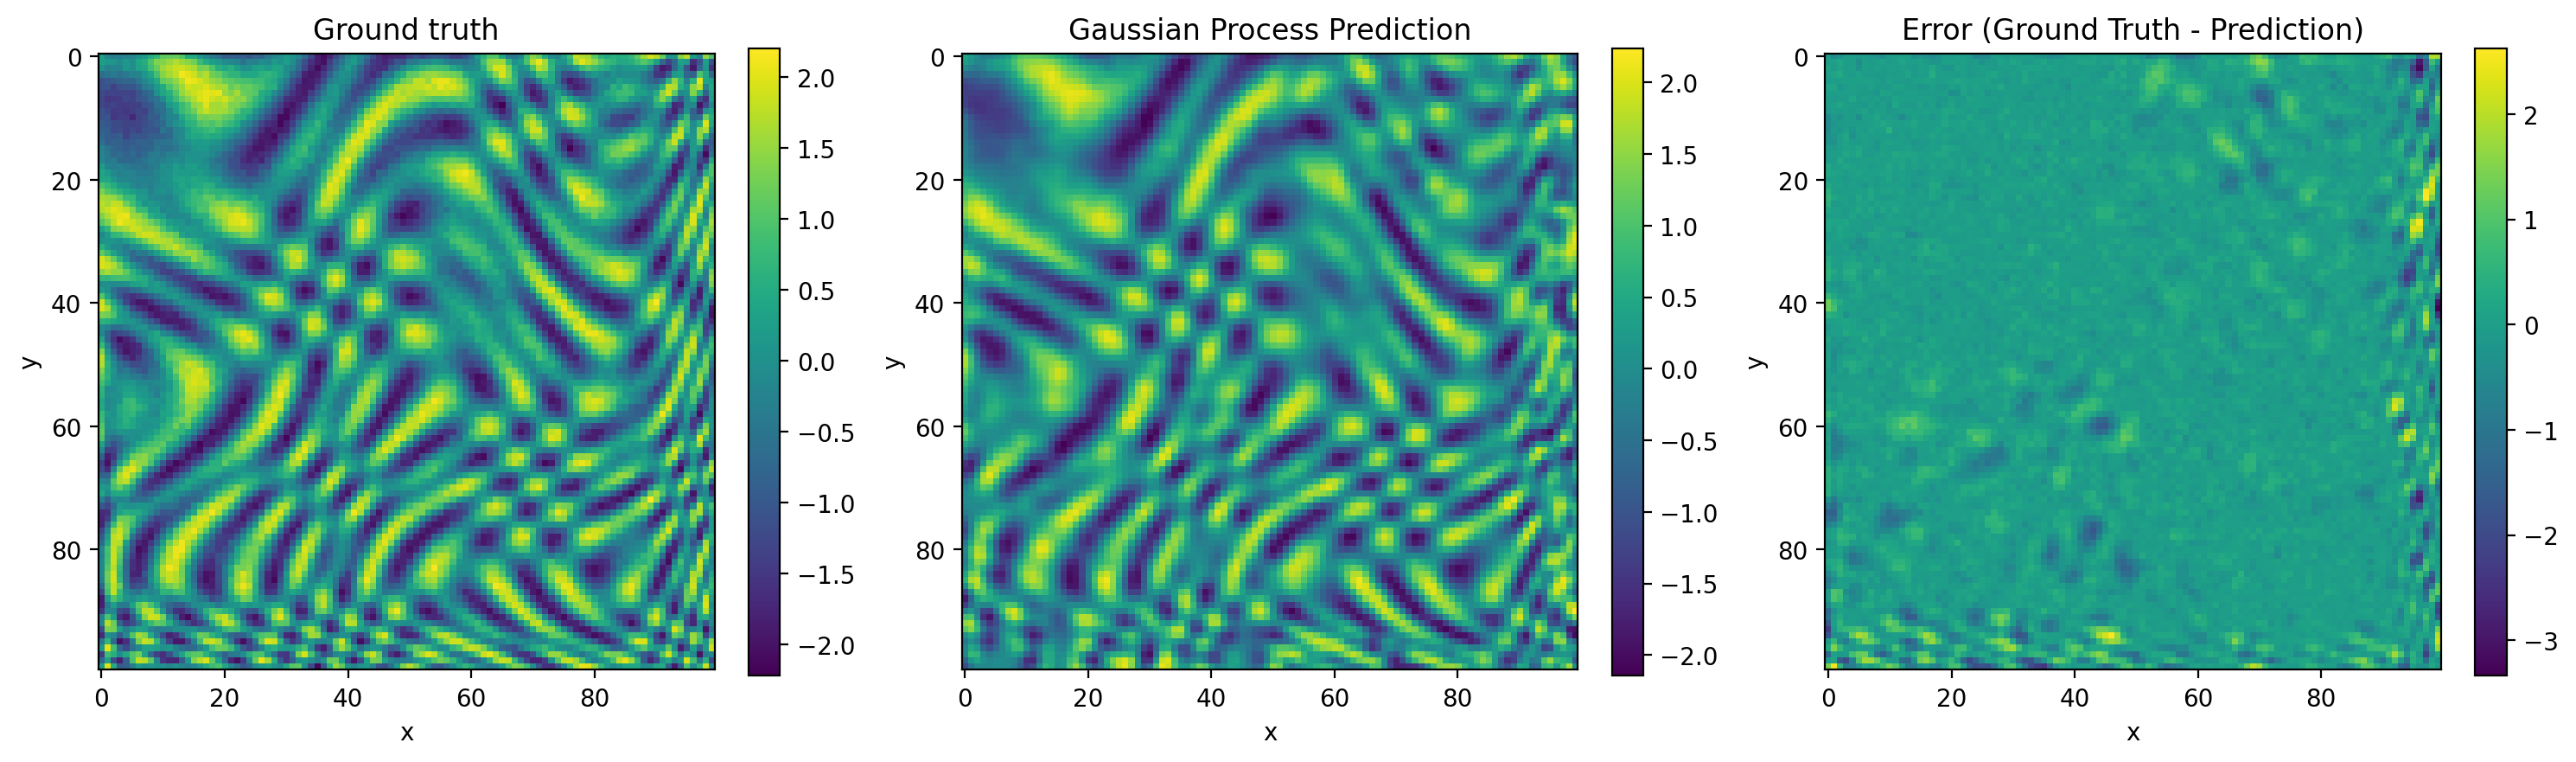

In [92]:
%matplotlib inline
# Ground truth, Prediction, Error
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(131)
im1 = ax1.imshow(z, cmap='viridis')
ax1.set_title('Ground truth')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
plt.colorbar(im1, ax=ax1, fraction=0.046)

ax2 = fig.add_subplot(132)
im2 = ax2.imshow(z_gp, cmap='viridis')
ax2.set_title('Gaussian Process Prediction')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
plt.colorbar(im2, ax=ax2, fraction=0.046)

ax3 = fig.add_subplot(133)
im3 = ax3.imshow(z - z_gp, cmap='viridis')
ax3.set_title('Error (Ground Truth - Prediction)')
ax3.set_xlabel('x')
ax3.set_ylabel('y')
plt.colorbar(im3, ax=ax3, fraction=0.046)

plt.tight_layout()
plt.savefig('GP_comparison.png', dpi=300, bbox_inches='tight')
plt.show()



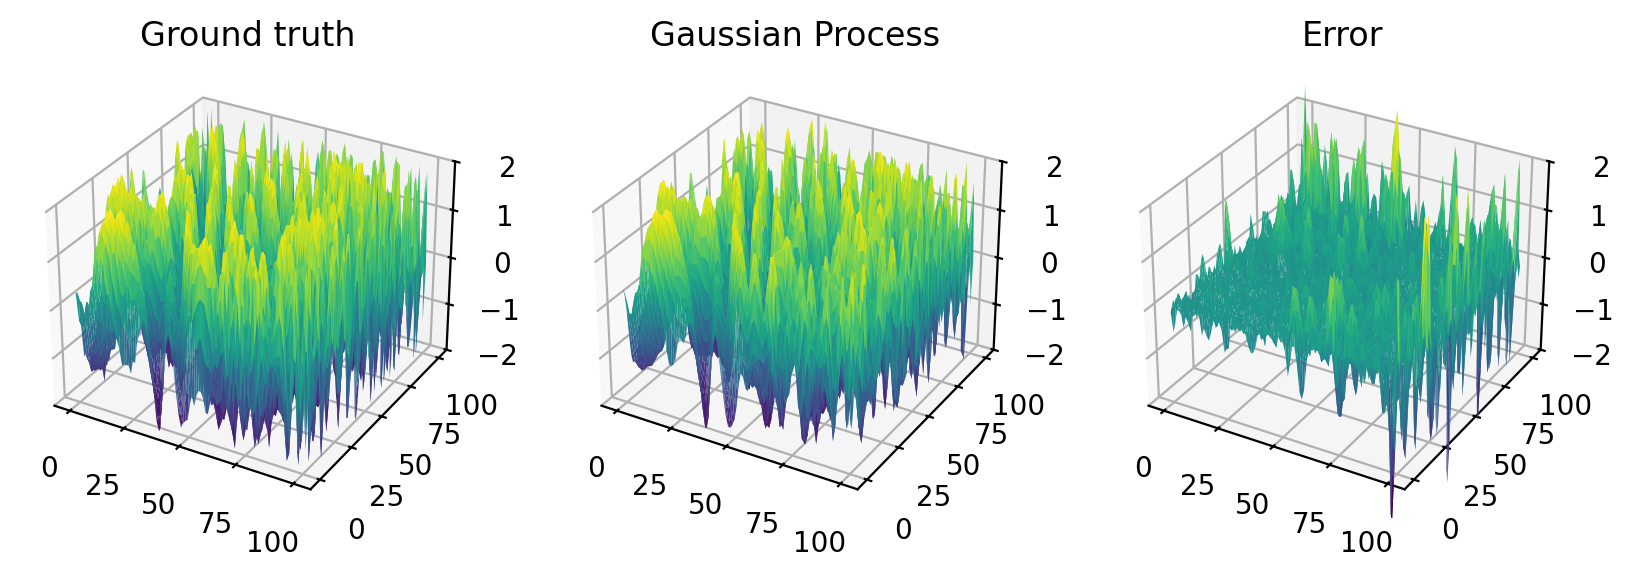

In [93]:
%matplotlib inline
# plot the 3D surface 
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(x, y, z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax1.set_title('Ground truth')
ax1.set_zbound([-2,2])

# plot the Gaussian Process prediction
ax2 = fig.add_subplot(132, projection='3d')
# ax2.scatter3D(train_x, train_y, train_z, c='red',zorder=3)
ax2.plot_surface(x, y, z_gp, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax2.set_title('Gaussian Process')
ax2.set_zbound([-2,2])

# plot the error
ax3 = fig.add_subplot(133, projection='3d')
ax3.plot_surface(x, y, z - z_gp, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax3.set_title('Error')
ax3.set_zbound([-2,2])
plt.show()

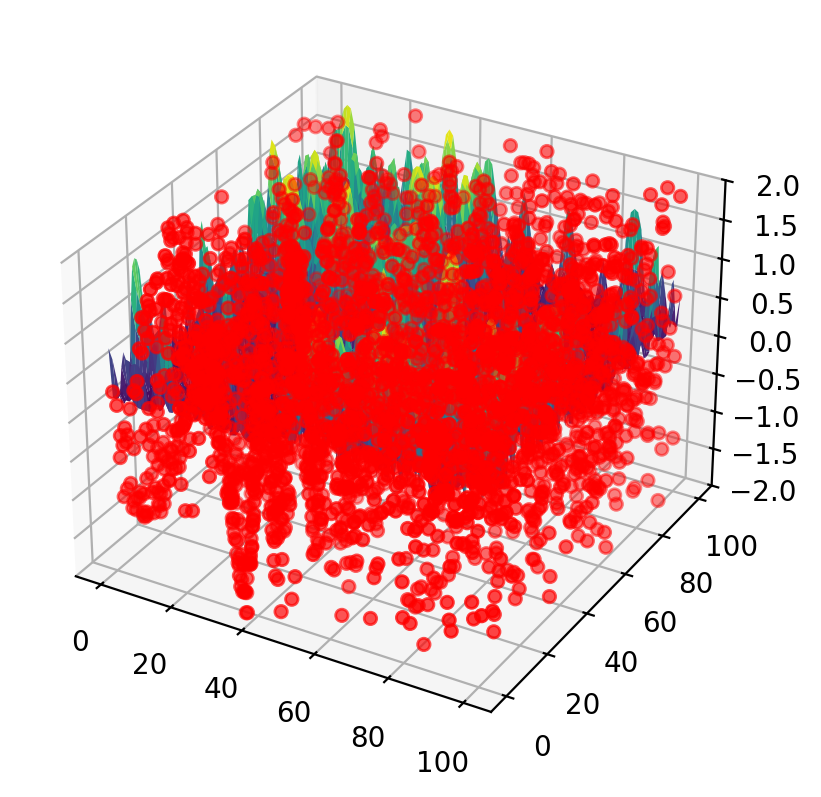

In [94]:
%matplotlib inline

# plot the 3D surface
fig = plt.figure()
ax = plt.axes(projection='3d') # create a 3D axes
ax.plot_surface(x,y,std_gp*2,rstride=1, cstride=1,
                cmap='viridis', edgecolor='none') # plot the 3D surface
ax.scatter3D(train_x, train_y, train_z, c='red') # plot the training data
ax.set_zbound([-2,2]) # set the z-axis bounds
plt.show() # show the plot

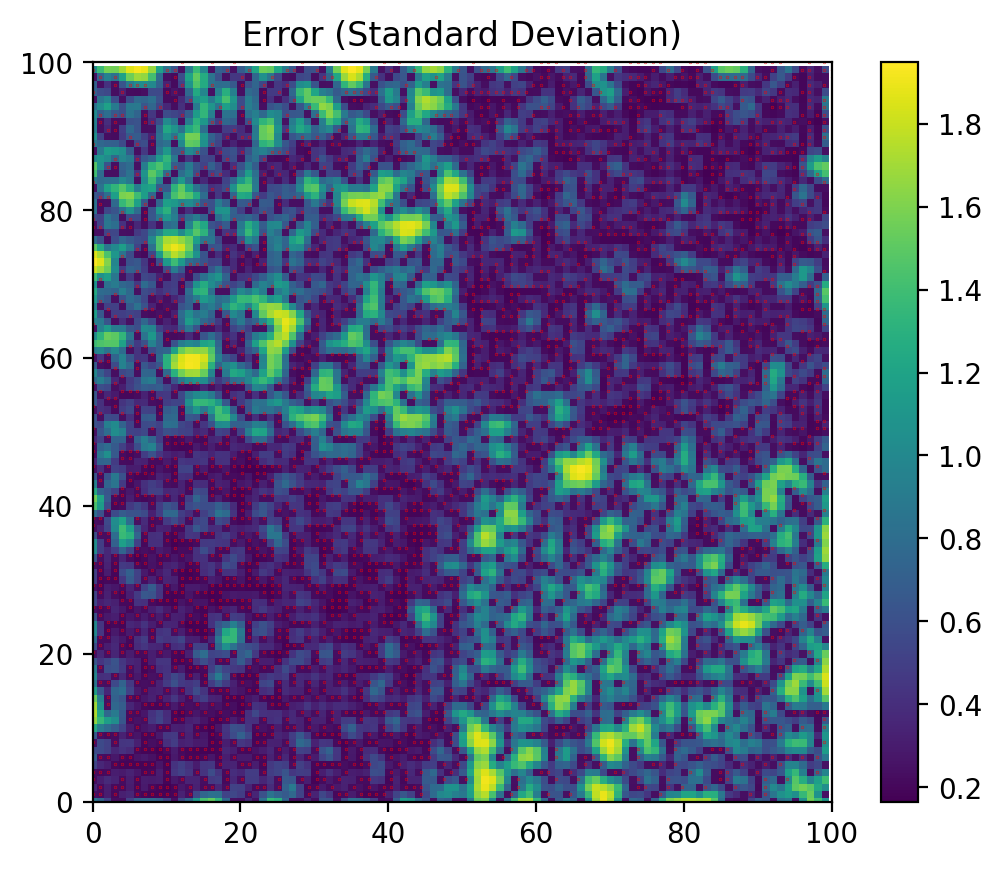

In [95]:
%matplotlib inline
fig = plt.figure()
ax = plt.axes()
mappable = ax.imshow(std_gp*2, cmap='viridis')
ax.scatter(train_x, train_y, c='red',s=0.1,marker='.')
ax.set_title('Error (Standard Deviation)')
plt.colorbar(mappable)
ax.set_xlim([0,100])
ax.set_ylim([0,100])
plt.savefig('std.svg')
plt.show()

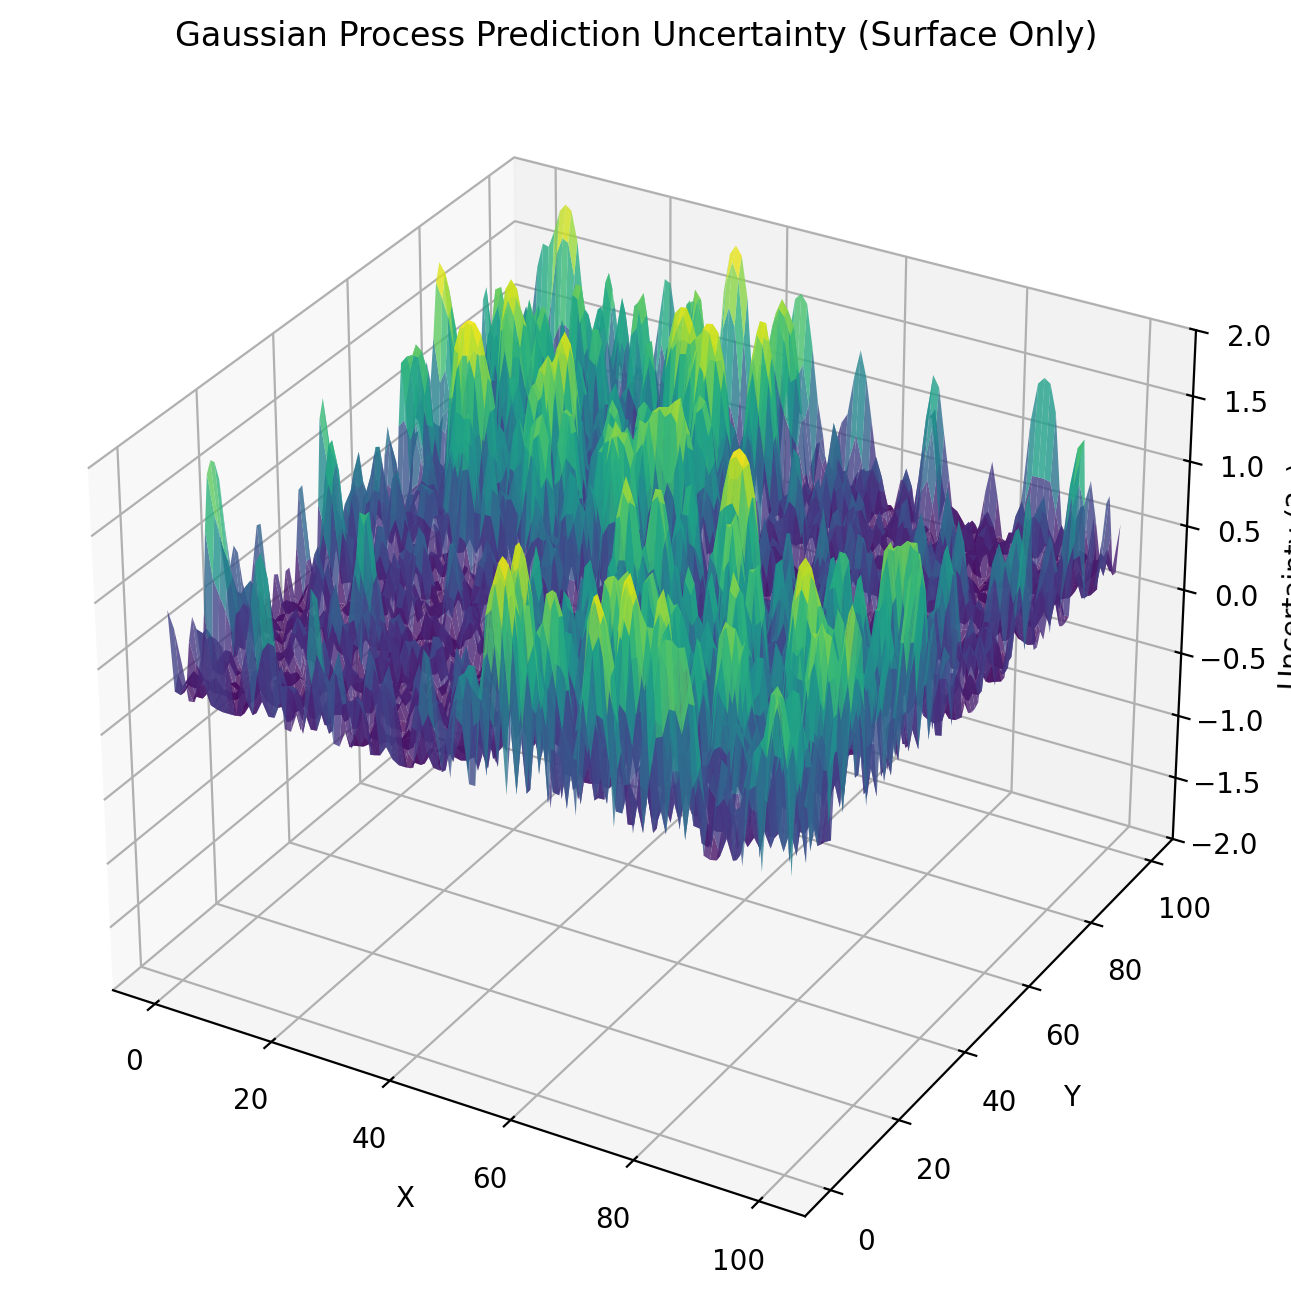

In [96]:
%matplotlib inline

# plot the 3D surface with only the surface plot
fig = plt.figure(figsize=(10, 8)) # create a figure with size 10x8
ax = plt.axes(projection='3d') # create a 3D axes
ax.plot_surface(x,y,std_gp*2,rstride=1, cstride=1, # plot the 3D surface
                cmap='viridis', edgecolor='none', alpha=0.8) # set the color map and edge color
ax.set_zbound([-2,2])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Uncertainty (2σ)')
ax.set_title('Gaussian Process Prediction Uncertainty (Surface Only)')
plt.show()

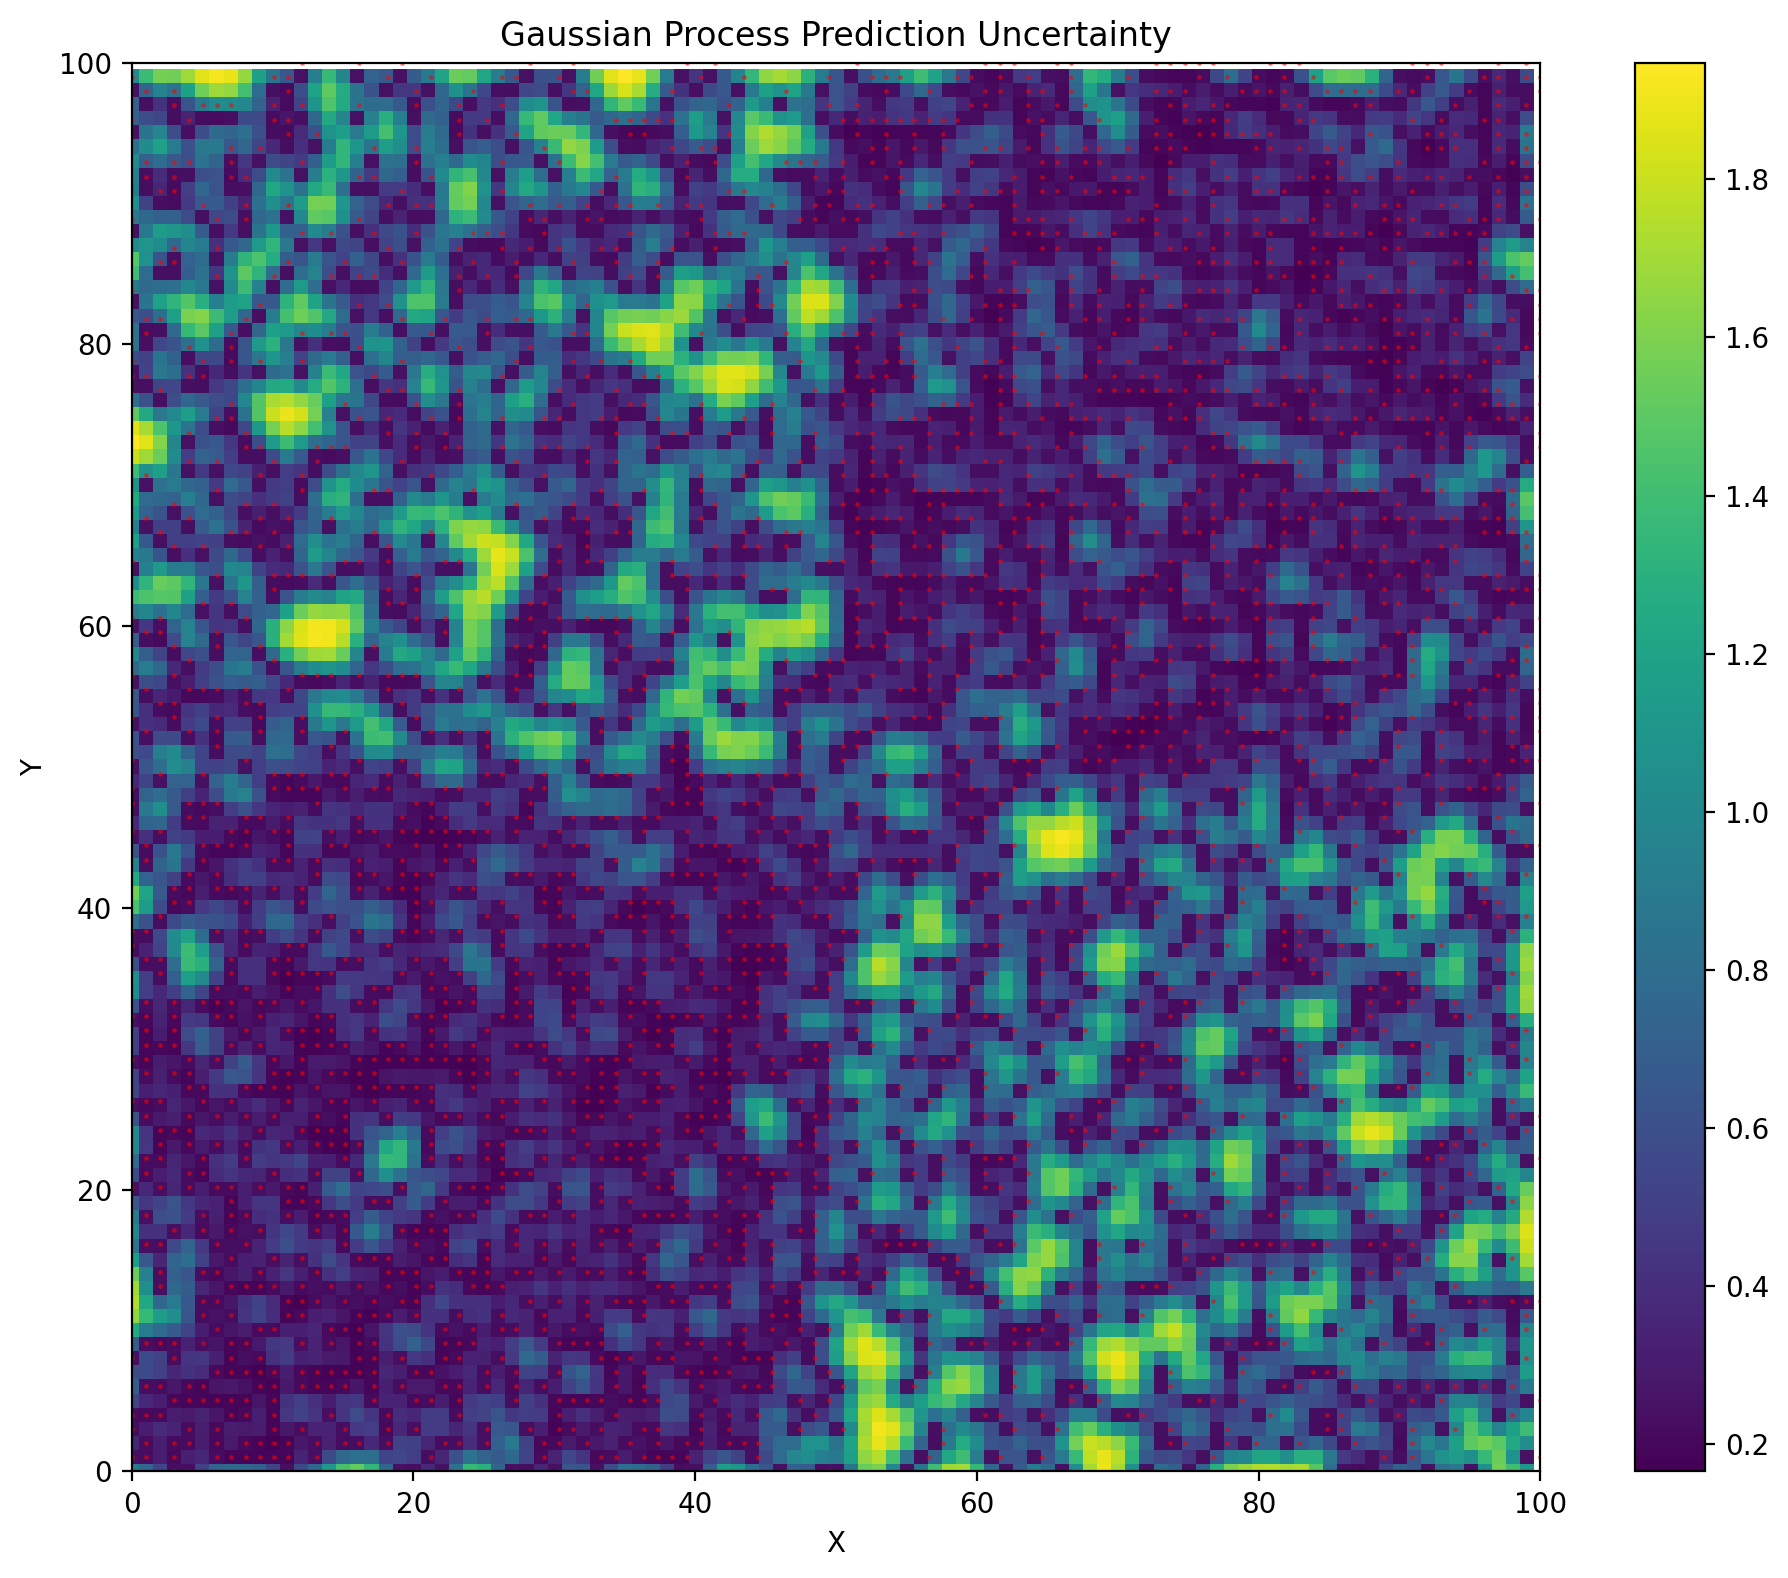

In [97]:
%matplotlib inline

# plot the 2D uncertainty heatmap
fig = plt.figure(figsize=(10, 8))
ax = plt.axes()
mappable = ax.imshow(std_gp*2, cmap='viridis')
ax.scatter(train_x, train_y, c='red', s=0.5, alpha=0.5)
plt.colorbar(mappable, ax=ax, fraction=0.046)
ax.set_xlim([0, 100])
ax.set_ylim([0, 100])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Gaussian Process Prediction Uncertainty')
plt.tight_layout()
plt.show()

In [98]:
res


  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 2225.9586964998252
        x: [ 5.556e+00  9.837e-01  1.538e-02]
      nit: 14
      jac: [ 1.819e-04 -9.095e-05 -4.093e-03]
     nfev: 80
     njev: 20
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

In [99]:
sse  = np.sum((z_gp - z)**2)  # squared error
rmse = np.sqrt(np.mean((z_gp - z)**2)) # root mean square error
print('SSE: {:.2f}   RMSE: {:.4f}'.format(sse, rmse))

SSE: 1399.89   RMSE: 0.3742


# UNIFORMLY DISTRIBUTED CASE

In [100]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# 30% training data for Gaussian Process model training using random sampling 
np.random.seed(1234)  
mask = np.random.uniform(low=0,high=1.0,size=(100,100))
p = 2949/10000 # 30% training data
mask = mask<p
print('the number of training samples: {}'.format(np.sum(mask)))

train_x = x[mask].reshape([-1,1]) # training data x
train_y = y[mask].reshape([-1,1]) # training data y
train_z = z[mask].reshape([-1]) # training data z

train_X = np.concatenate([train_x.reshape([-1,1]), train_y.reshape([-1,1])], axis=1) # training data X 



the number of training samples: 2967


In [101]:
# optimize the negative log likelihood to get the best parameters
res = minimize(NLL,
               x0=np.array([2.25,1,0.25]),  # initial values: l2, s2, e2
               method='L-BFGS-B',
               bounds=((1e-5, None), (1e-5, None), (1e-5, None)))  # bounds for the parameters

In [102]:
l2_opt, s2_opt, e2_opt = res.x
print(f'Optimized params -> length^2: {l2_opt:.4f}, var: {s2_opt:.4f}, noise: {e2_opt:.4f}')

Optimized params -> length^2: 5.5510, var: 0.9926, noise: 0.0175


In [117]:
# predict the z value using the Gaussian Process model
z_gp, cov_gp = prediction(train_X, train_z, test_X, SE_kernel_2d, res.x[:-1], res.x[-1], return_std=True)
z_gp = z_gp.reshape(x.shape)
std_gp = np.sqrt(np.diag(cov_gp)).reshape(x.shape)

In [118]:
import numpy as np
sse  = np.sum((z_gp - z)**2)  # squared error
rmse = np.sqrt(np.mean((z_gp - z)**2)) # root mean square error
print(f'SSE: {sse:.2f}   RMSE: {rmse:.4f}')

SSE: 1002.81   RMSE: 0.3167


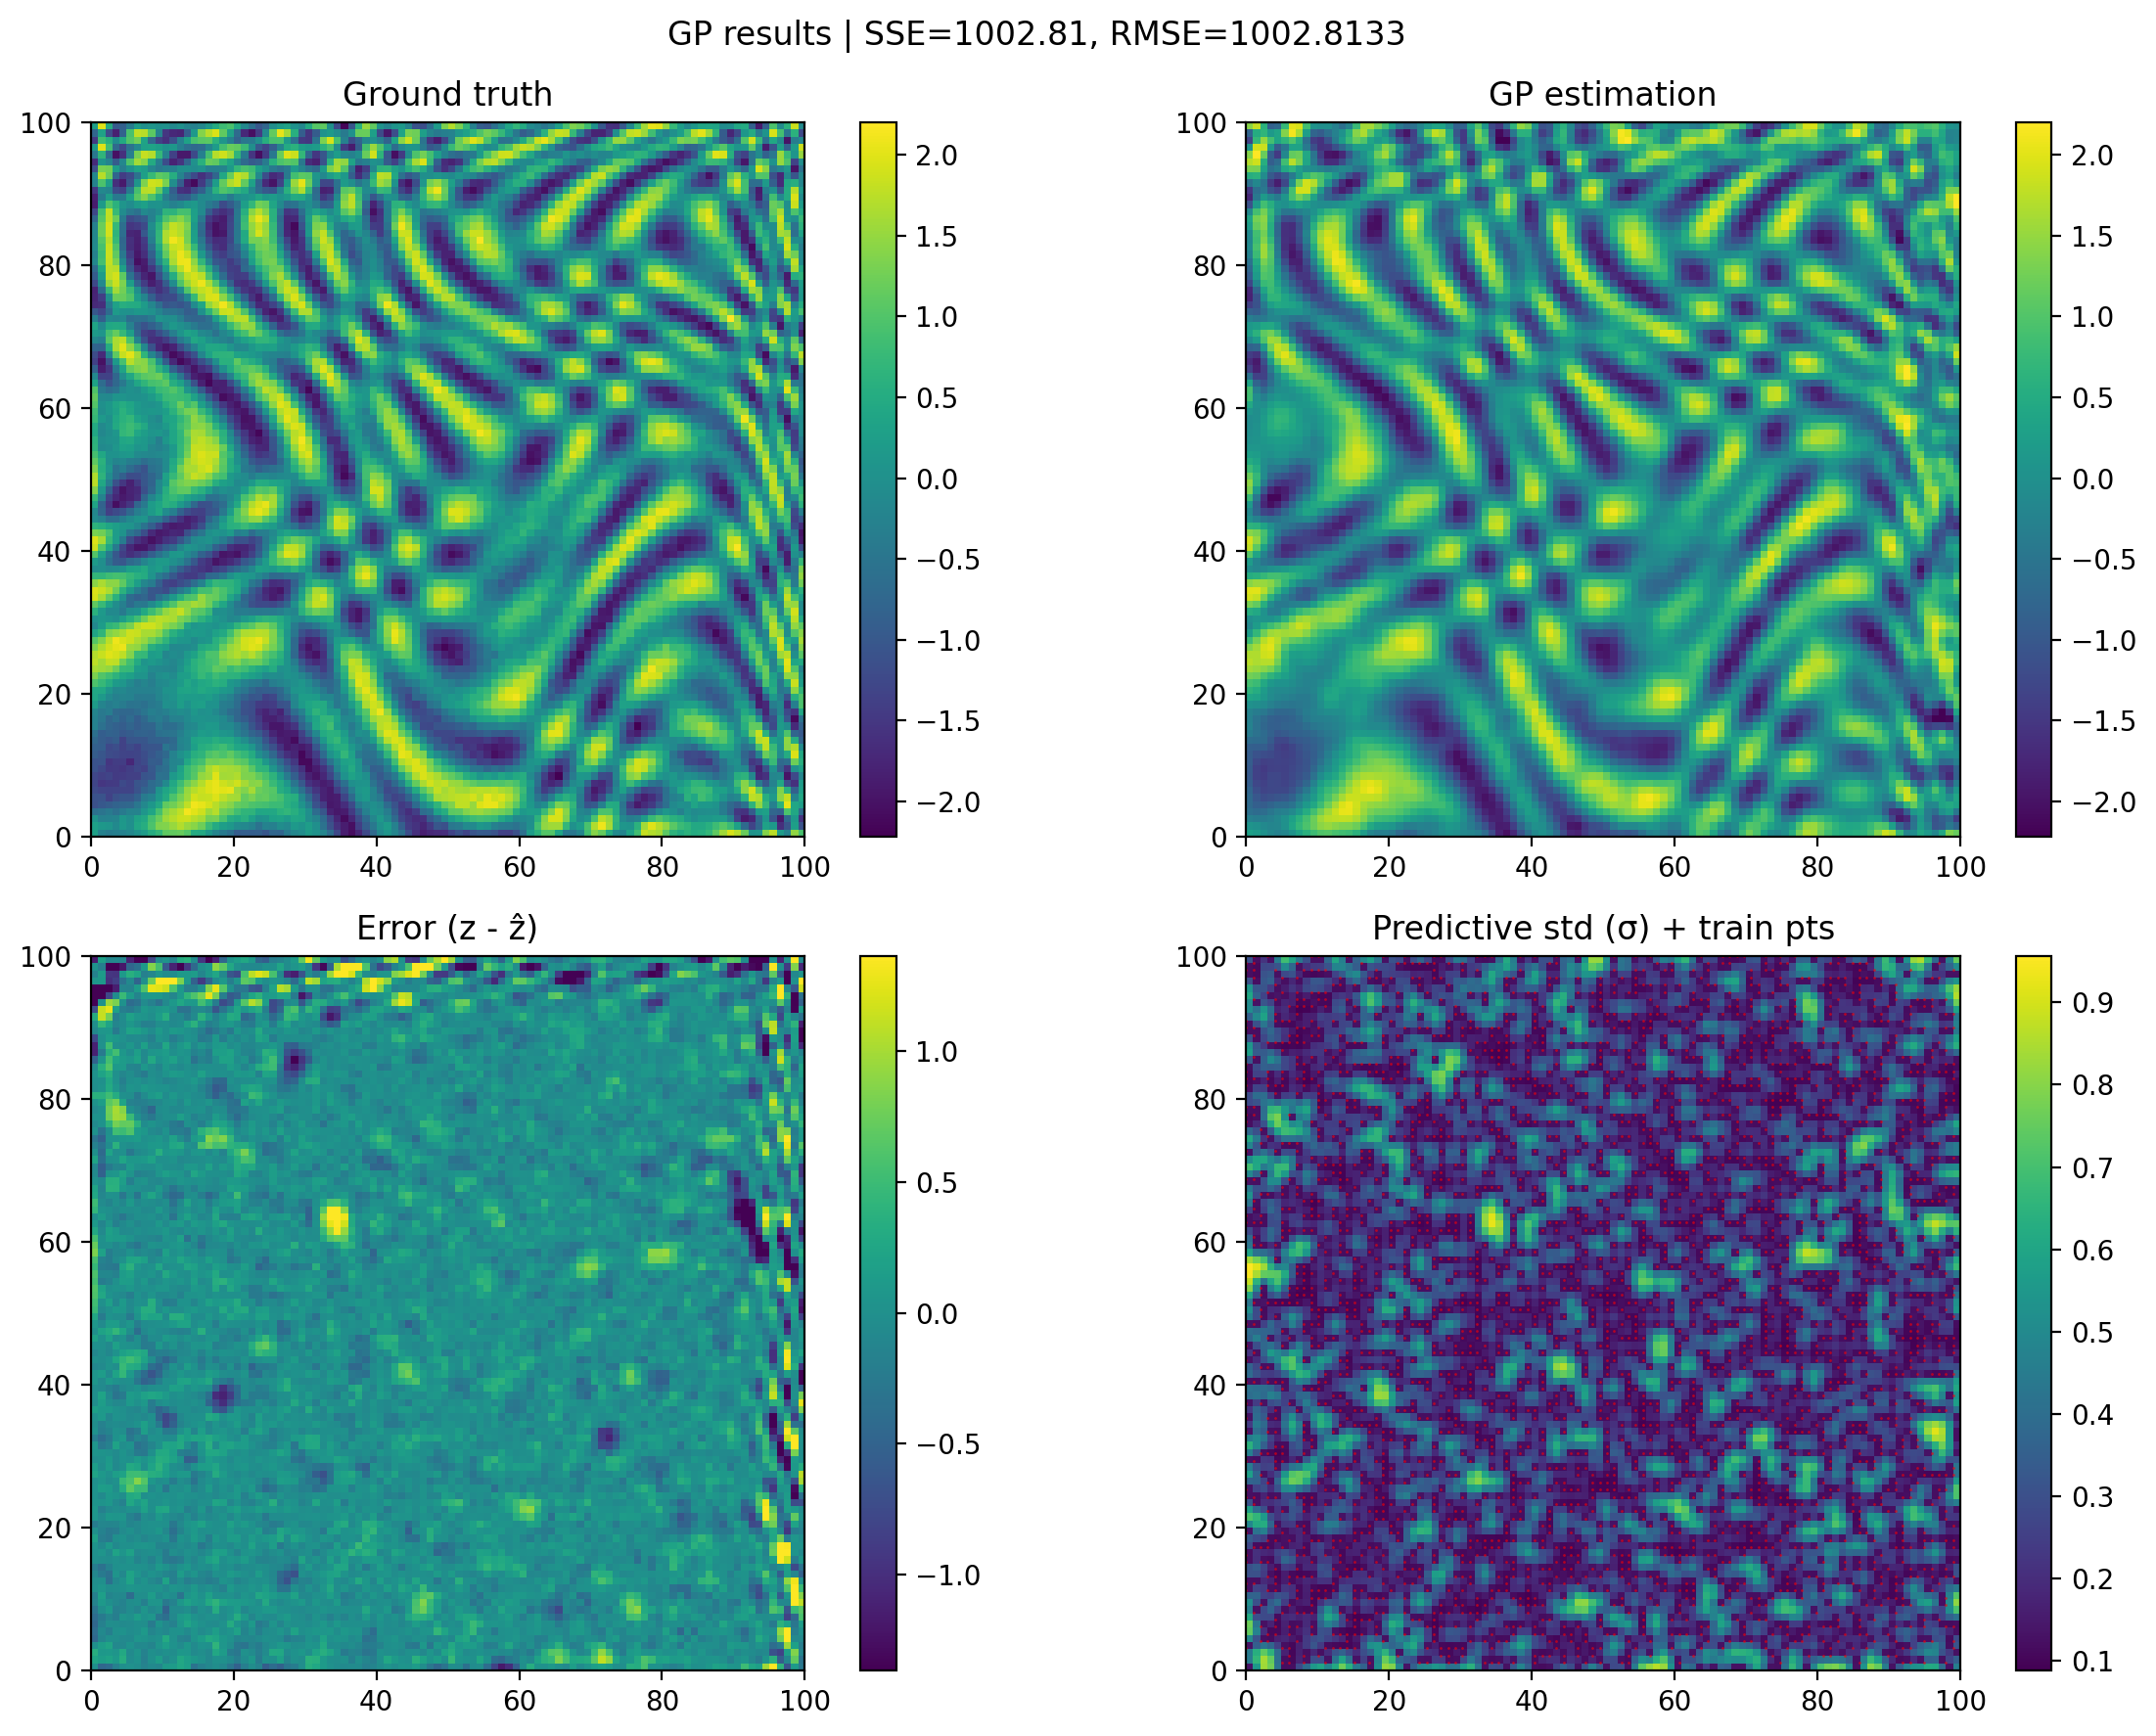

In [135]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# plot the ground truth, Gaussian Process estimation, error, and predictive standard deviation
H, W = z.shape

def to_hw(a, name):
    a = np.asarray(a)
    if a.ndim == 1 and a.size == H*W:
        return a.reshape(H, W)
    if a.shape != (H, W):
        raise ValueError(f"{name} shape {a.shape} != {(H, W)}")
    return a

z_plot     = np.where(np.isfinite(z),      z,      np.nan)
z_gp_plot  = to_hw(z_gp,  "z_gp")
z_gp_plot  = np.where(np.isfinite(z_gp_plot),  z_gp_plot,  np.nan)
std_plot   = to_hw(std_gp, "std_gp")
std_plot   = np.where(np.isfinite(std_plot),   std_plot,   np.nan)

# color range for the ground truth and Gaussian Process estimation
vmin, vmax = np.nanmin(z_plot), np.nanmax(z_plot)  # uniform for the ground truth and Gaussian Process estimation
err = z_plot - z_gp_plot

err_abs = np.nanpercentile(np.abs(err), 99)  

# plot the results
plt.rcParams['figure.figsize'] = (12, 9)
fig, axs = plt.subplots(2, 2)
extent = [0, 100, 0, 100]

im0 = axs[0,0].imshow(
    z_plot, origin='lower', cmap='viridis',
    vmin=vmin, vmax=vmax, extent=extent, aspect='equal'
)
axs[0,0].set_title('Ground truth')
plt.colorbar(im0, ax=axs[0,0])

im1 = axs[0,1].imshow(
    z_gp_plot, origin='lower', cmap='viridis',
    vmin=vmin, vmax=vmax, extent=extent, aspect='equal'
)
axs[0,1].set_title('GP estimation')
plt.colorbar(im1, ax=axs[0,1])

im2 = axs[1,0].imshow(
    err, origin='lower', cmap='viridis',
    vmin=-err_abs, vmax=err_abs,           
    extent=extent, aspect='equal'
)
axs[1,0].set_title('Error (z - ẑ)')
plt.colorbar(im2, ax=axs[1,0])

im3 = axs[1,1].imshow(
    std_plot, origin='lower', cmap='viridis',
    extent=extent, aspect='equal'
)
axs[1,1].scatter(np.asarray(train_x).reshape(-1),
                 np.asarray(train_y).reshape(-1),
                 c='red', s=1, alpha=0.6, linewidths=0)
axs[1,1].set_title('Predictive std (σ) + train pts')
plt.colorbar(im3, ax=axs[1,1])

for ax in axs.ravel():
    ax.set_xlim(0, 100); ax.set_ylim(0, 100)

# title for the results
title = 'GP results'
try:
    title += f' | SSE={sse:.2f}, RMSE={rmse:.4f}'
except NameError:
    pass
fig.suptitle(title, y=0.98)

plt.tight_layout()
plt.savefig('gp_results.svg', bbox_inches='tight')
plt.show()


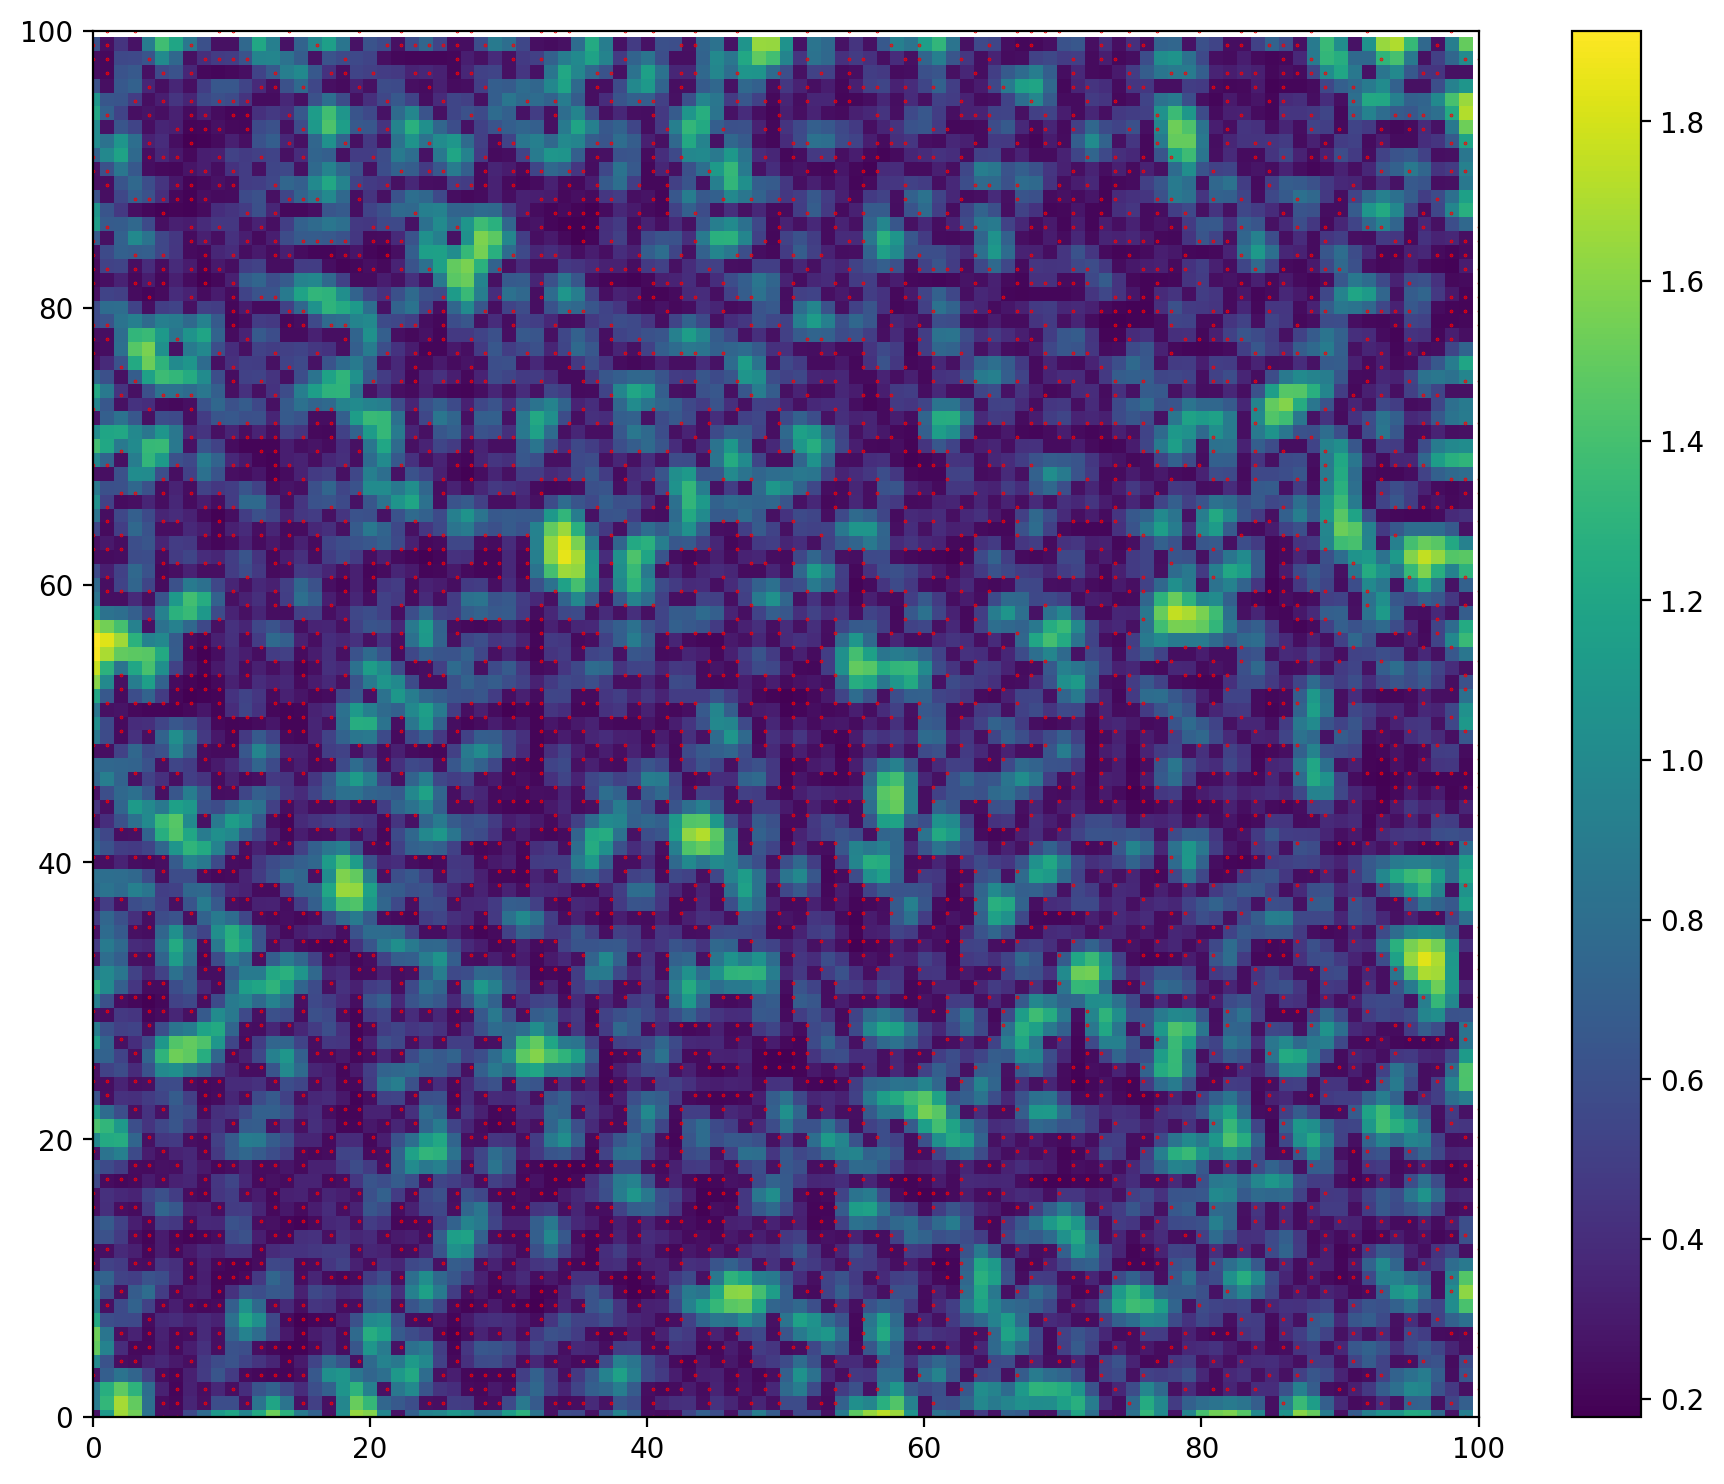

In [136]:
# plot the error of the Gaussian Process model
%matplotlib inline
fig = plt.figure()
ax = plt.axes()
mappable = ax.imshow(std_gp*2, cmap='viridis')
ax.scatter(train_x, train_y, c='red',s=0.1)
plt.colorbar(mappable)
ax.set_xlim([0,100])
ax.set_ylim([0,100])
plt.savefig('error_improve.svg')
plt.show()

In [137]:
# plot the error of the Gaussian Process model
print(res.fun)
rmse = np.sum((z_gp-z)**2)
print(rmse)

2381.6107908092695
1002.8132882045988
